In [1]:
import os
import math
import torch
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm import tqdm
import  matplotlib.pyplot as plt
from transformers import T5Tokenizer, T5ForConditionalGeneration,  DataCollatorWithPadding
from datasets import load_dataset, DatasetDict, Dataset
from torch.utils.data import DataLoader

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# 1. 데이터 전처리

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

tokenizer = T5Tokenizer.from_pretrained("google/t5-v1_1-small")

# model = T5ForConditionalGeneration.from_pretrained("google/t5-v1_1-small", output_hidden_states=True)
# model = T5ForConditionalGeneration.from_pretrained("google/t5-v1_1-base", output_hidden_states=True)
# model = T5ForConditionalGeneration.from_pretrained("google/t5-v1_1-large", output_hidden_states=True)
# model = T5ForConditionalGeneration.from_pretrained("google/t5-v1_1-xl", output_hidden_states=True)

model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-small", output_hidden_states=True)
# model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base", output_hidden_states=True)
# model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large", output_hidden_states=True)
# model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-xl", output_hidden_states=True)

model = model.to(device)

In [3]:
dataset = load_dataset('HuggingFaceH4/databricks_dolly_15k')
#dataset = load_dataset('HuggingFaceH4/asss')

df  = pd.DataFrame(dataset['train'])
df.groupby('category').count()

Found cached dataset parquet (/home/uj-user/.cache/huggingface/datasets/HuggingFaceH4___parquet/HuggingFaceH4--databricks_dolly_15k-6252f3495e7d2b9d/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

,instruction,input,output
category,,,
brainstorming,1768,1768,1768
classification,2136,2136,2136
closed_qa,1823,1823,1823
creative_writing,711,711,711
general_qa,2191,2191,2191
information_extraction,1512,1512,1512
open_qa,3611,3611,3611
summarization,1263,1263,1263


In [4]:
['category', 'instruction', 'input', 'output', 'attention_mask', 'decoder_input_ids']

['category',
 'instruction',
 'input',
 'output',
 'attention_mask',
 'decoder_input_ids']

In [5]:
df['category'].value_counts()

category
open_qa                   3611
general_qa                2191
classification            2136
closed_qa                 1823
brainstorming             1768
information_extraction    1512
summarization             1263
creative_writing           711
Name: count, dtype: int64

In [6]:
# 카테고리 전처리
prep_df = df[df['category']!='']#[:5000]
prep_df['category'] = prep_df['category'].apply(lambda x: 'Commonsense/logic' if x=="Common Sense / Logic" else x)
prep_df = prep_df.sort_values('category')

prep_data = Dataset.from_pandas(prep_df, preserve_index=False)
dataset = DatasetDict({'train':prep_data})
dataset

DatasetDict({
    train: Dataset({
        features: ['category', 'instruction', 'input', 'output'],
        num_rows: 15015
    })
})

In [7]:
def preprocess_function(example):
    return tokenizer(example["instruction"], truncation=True, padding=False, max_length=128)

tokenized_datasets = dataset.map(preprocess_function, batched=True)
tokenized_datasets['train'] = tokenized_datasets['train'].rename_column("input_ids", "encoder_input_ids")
tokenized_datasets['train'] = tokenized_datasets['train'].remove_columns(['attention_mask'])

def preprocess_func(example):
    return tokenizer(example["output"], truncation=True, padding=False)

tokenized_datasets = tokenized_datasets.map(preprocess_func, batched=True)
tokenized_datasets['train'] = tokenized_datasets['train'].rename_column("input_ids", "decoder_input_ids")
#tokenized_datasets['train'] = tokenized_datasets['train'].remove_columns(['id', 'source', 'category', 'subcategory', 'prompt', 'input', 'output'])

tokenized_datasets.set_format("torch")
tokenized_datasets

Map:   0%|          | 0/15015 [00:00<?, ? examples/s]

Map:   0%|          | 0/15015 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['category', 'instruction', 'input', 'output', 'encoder_input_ids', 'decoder_input_ids', 'attention_mask'],
        num_rows: 15015
    })
})

In [8]:
batch_size = 2

encoder_datasets = tokenized_datasets['train'].remove_columns(['category', 'instruction', 'input', 'output', 'attention_mask', 'decoder_input_ids'])
decoder_datasets = tokenized_datasets['train'].remove_columns(['category', 'instruction', 'input', 'output', 'attention_mask', 'encoder_input_ids'])

encoder_datasets = encoder_datasets.rename_column('encoder_input_ids','input_ids')
decoder_datasets = decoder_datasets.rename_column('decoder_input_ids','input_ids')

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
encoder_dataloader = DataLoader(encoder_datasets, batch_size=batch_size, shuffle=False, collate_fn=data_collator, drop_last=True)
decoder_dataloader = DataLoader(decoder_datasets, batch_size=batch_size, shuffle=False, collate_fn=data_collator, drop_last=True)
encoder_datasets

Dataset({
    features: ['input_ids'],
    num_rows: 15015
})

# 2. 모델 Inference

In [9]:
def _get_model_hidden_states(outputs, encoder_style:str):
    if encoder_style=="encoder":
        hs = outputs.encoder_hidden_states
    elif encoder_style=="decoder":
        hs = outputs.decoder_hidden_states#.detach().cpu().numpy()
    else:
        print('Error: model style not properly selected.')
    return hs

def _get_layer_hidden_states(hs, layer_style:str):
    if layer_style=="first":
        hs = hs[0].detach().cpu().numpy()
    elif layer_style=="last":
        hs = hs[-1].detach().cpu().numpy()
    elif layer_style=="avg":
        hs = torch.mean(torch.stack(hs, axis=0), axis=0).detach().cpu().numpy()
    elif layer_style=="avg_last4":
        hs = torch.mean(torch.stack(hs[-4:], axis=0), axis=0).detach().cpu().numpy()
    else:
        print('Error: layer style not properly selected.')
    return hs

def _get_element_hidden_states(hs, element_style:str):
    if element_style=="cls":
        hs = hs[:, 0, :]
    elif element_style=="last":
        hs = hs[:, -1, :]
    elif element_style=="avg":
        hs = np.mean(hs, axis=1)
    else:
        print('Error: layer style not properly selected.')
    return hs

# encoderwise, layerwise, elementwise
def get_hidden_states(outputs, encoder_style:str, layer_style:str, element_style:str):
    """ 
    model : ['encoder', 'decoder']
    layer_style : ['first', 'last', 'avg', avg_last4]
    element_style : ['cls', 'last', 'avg', ]
    """
    hs = _get_model_hidden_states(outputs, encoder_style)
    layer_hs = _get_layer_hidden_states(hs, layer_style)
    element_hs = _get_element_hidden_states(layer_hs, element_style) # optional use for only one embedding
    return element_hs

def get_dataset_hidden_states(encoder_style:str, layer_style:str, element_style:str):
    hs_list = []
    for inputs, labels in zip(encoder_dataloader, decoder_dataloader):
        input_ids = inputs.input_ids.to(device="cuda")
        labels = labels.input_ids.to(device="cuda")
        outputs = model(input_ids=input_ids, labels=labels)

        hs = get_hidden_states(outputs, encoder_style=encoder_style, layer_style=layer_style, element_style=element_style)
        hs_list.append(hs)
    return np.array(hs_list).reshape([-1, hs.shape[-1]])

def get_category_group_hidden_states(encoder_style:str, layer_style:str, element_style:str, category:str):
    hs_list = []
    for i, batch in enumerate(tokenized_datasets['train']):
        if batch['category']==category:
            input_ids = torch.unsqueeze(batch['encoder_input_ids'], 0).to(device="cuda")
            labels = torch.unsqueeze(batch['decoder_input_ids'], 0).to(device="cuda")
            outputs = model(input_ids=input_ids, labels=labels)
            hs = get_hidden_states(outputs, encoder_style=encoder_style, layer_style=layer_style, element_style=element_style)
            hs_list.append(hs)
    return np.mean(np.array(hs_list), axis=0)

# hs_list = get_hidden_states(outputs, encoder_style='encoder', layer_style='last', element_style='last')
# hs_list = get_dataset_hidden_states(encoder_style='encoder', layer_style='last', element_style='cls')

# hs_enc_last_cls = get_dataset_hidden_states(encoder_style='encoder', layer_style='last', element_style='cls')
# hs_enc_last_cls.shape

In [10]:
input_ids = tokenizer("Suggest a related search term to watermelon", return_tensors="pt").input_ids.to(device)
labels = tokenizer("Suggest a related search term to watermelon", return_tensors="pt").input_ids.to(device)
outputs = model(input_ids=input_ids, labels=labels)

print(outputs.keys())
print('decoder layer len:', len(outputs.decoder_hidden_states))
print(outputs.decoder_hidden_states[0].shape)

odict_keys(['loss', 'logits', 'past_key_values', 'decoder_hidden_states', 'encoder_last_hidden_state', 'encoder_hidden_states'])
decoder layer len: 9
torch.Size([1, 13, 512])


# 3. 시각화

In [11]:
hs_dec_last_last = get_dataset_hidden_states(encoder_style='encoder', layer_style='last', element_style='cls')
print(hs_dec_last_last.shape)

(15014, 512)


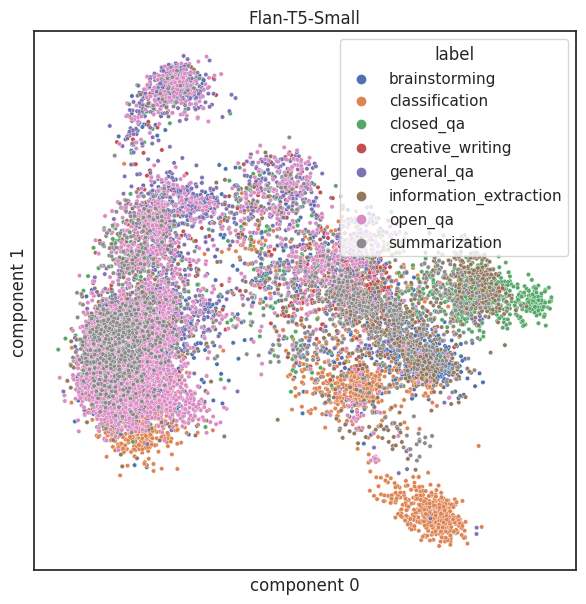

In [12]:
from sklearn.decomposition import PCA

n_components =2 
pca = PCA(n_components =n_components, random_state=0)
pca_np = pca.fit_transform(hs_dec_last_last)

dataset_len = len(tokenized_datasets['train'])
data_length = dataset_len - dataset_len%batch_size

pca_df = pd.DataFrame(pca_np, columns = ['component 0', 'component 1'])
pca_df['label'] = tokenized_datasets['train']['category'][:data_length]

sns.set(rc={'figure.figsize':(7,7)})
sns.set_style("white")
ax = sns.scatterplot(x='component 0', y='component 1', hue='label', data=pca_df, s=10)
ax.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)
plt.title('Flan-T5-Small')

os.makedirs('./t5_pca_image/', exist_ok=True)
plt.savefig('./t5_pca_image/flan-small-enc.svg')

In [13]:
def visualize_batch_embedding(hs, output_name='output.png', figsize=(10,20), text=None):
    # (273, 512) # batch, embedding_dim
    fig, axs = plt.subplots(math.ceil(len(hs)/2), 2, figsize=figsize)
    axs = axs.ravel()
    for i in range(len(hs)):
        img = axs[i].imshow(np.expand_dims(hs[i], axis=0),  aspect='150', cmap='Greys')
        axs[i].set_title(tokenized_datasets['train']['category'][i], fontsize=10)
        axs[i].axis('off')
        if text:
            axs[i].set_title(text[i], fontsize=10)
    fig.savefig(output_name, dpi=300, bbox_inches='tight')
        
def visualize_embedding(hs, text=''):
    plt.imshow(np.expand_dims(np.mean(hs, axis=0), 0),  aspect='30', cmap='Greys')
    plt.axis('off')
    plt.title(text)

In [14]:
output_img_dir = 't5_image'
os.makedirs(output_img_dir, exist_ok=True)

cat_emb_list = []
category_list = prep_df['category'].value_counts().keys().tolist()
for cat in category_list:
    print(cat)
    cat_emb = get_category_group_hidden_states(encoder_style='encoder', layer_style='last', element_style='last', category=cat)
    cat_emb_list.append(np.squeeze(cat_emb))

cat_emb_arr = np.array(cat_emb_list)
print(cat_emb_arr.shape)

open_qa
general_qa
classification
closed_qa
brainstorming
information_extraction
summarization
creative_writing
(8, 512)


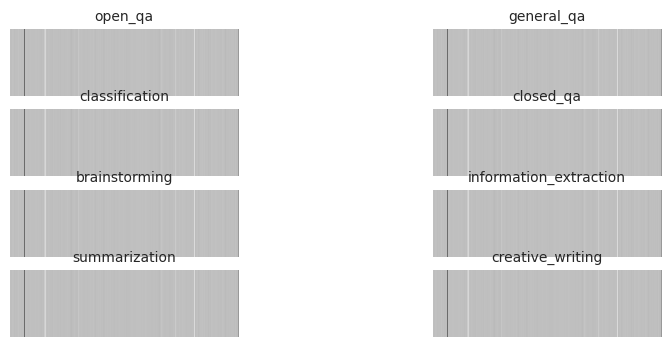

In [15]:
visualize_batch_embedding(cat_emb_arr, f'./{output_img_dir}/cat_emb.png', (10,4), category_list)

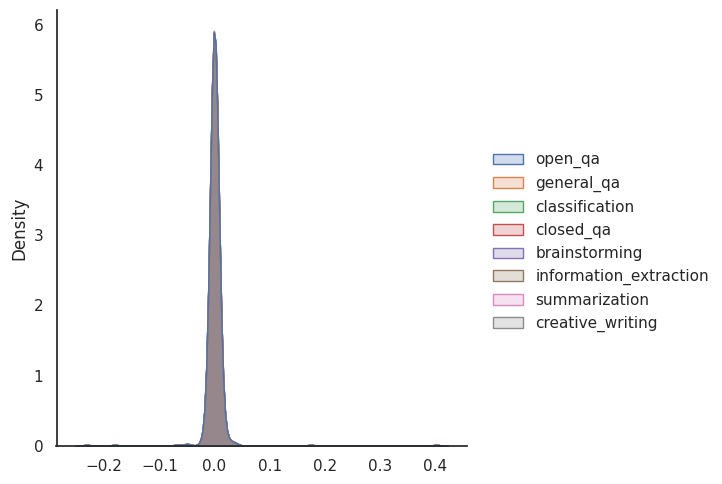

In [16]:
df_cat_emb = pd.DataFrame(cat_emb_arr.T, columns=category_list)
sns.displot(df_cat_emb, kind="kde", fill=True)#, hue="512")

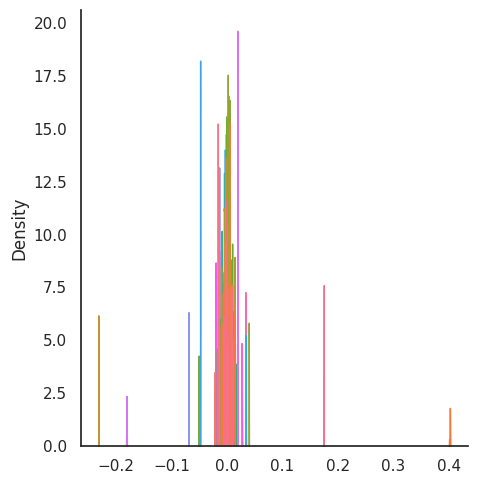

: 

In [17]:
df_cat_emb = pd.DataFrame(cat_emb_arr)
g = sns.displot(df_cat_emb, kind="kde", fill=True)#, hue="512")
g._legend.remove()